# Structural Similarity
### Till 27.03.2017 (task in the end of the file)

During this seminar we will:
1. Consider some node similarity measures, particularly: *Euclidean Distance*, *Correlation Coefficient* and *Cosine Distance*
2. Take a look at *[Cuthill-McKee](http://en.wikipedia.org/wiki/Cuthill%E2%80%93McKee_algorithm)* node reordering procedure
3. Calculate *Assortative mixing coefficient* for some **[Game Of Thrones](http://cdn.meme.am/instances/55597956.jpg)** network

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial as spt
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
%matplotlib inline

### Task 1 - Similarities Calculation

1. Calculate *Euclidean Distance*, *Correlation Coefficient* and *Cosine Distance* for some toy-network (Zachary again?) and for [Les Miserables](http://www-personal.umich.edu/~mejn/netdata/lesmis.zip) dataset
2. Visualize them

**HINT:**
For correlation coeficient you can use *np.corrcoef()*, for the distances you may implement them on your own or use *scipy.spatial.distance.pdist()*

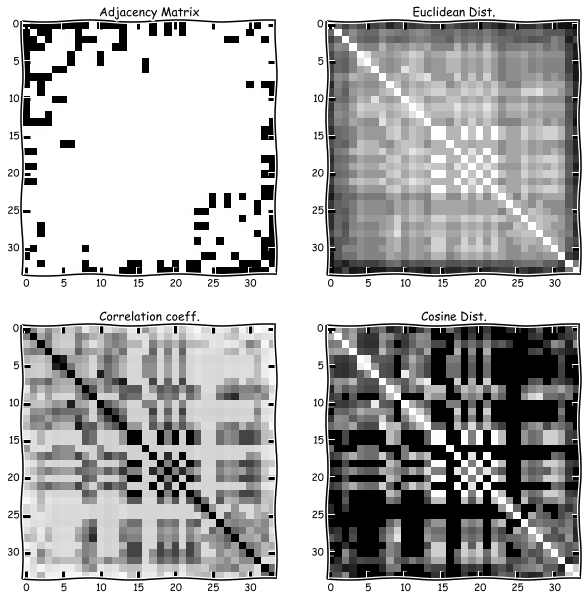

In [13]:
# Put your code here..
#
#
G = nx.karate_club_graph()
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)

def plotDist(A):
    
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, cmap = 'Greys', interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    
    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 1].set_title('Cosine Dist.')
    
plotDist(A)   
    

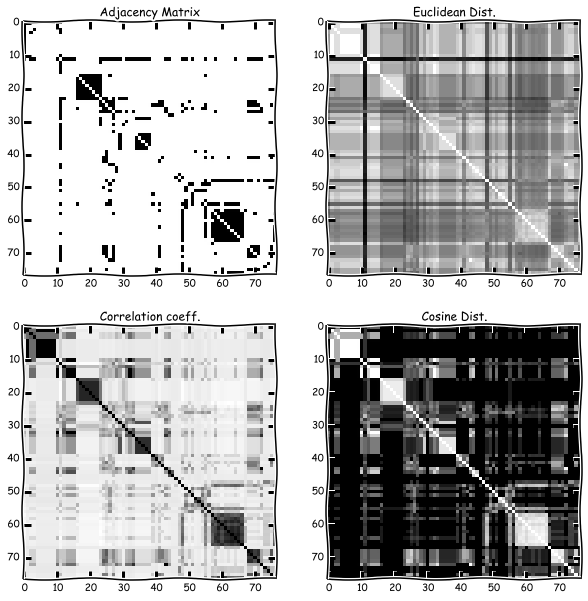

In [14]:
G = nx.read_gml('lesmis.gml')
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)

plotDist(A)

### Task 2 - Node Reordering

Without special preprocess procedures graph adjacency matrix can look very noisy and hide network's structure (just look at the matrices above). Offcourse usually you don't know the structure itself (communities, groups of closelly connected nodes, etc.) unless it is given, however there are some procedures of node reordering that provides a better view of the network's adjacency matrix.

*[Reverse Cuthill-McKee](http://en.wikipedia.org/wiki/Cuthill%E2%80%93McKee_algorithm)* finds permutation of the nodes that minimizes the **bandwidth** of the matrix, which is calculated as:
$$ \theta = \max_{a_{ij} > 0}|i-j|$$
Unformally, this algorithm puts some *mass* on the diagonal of adjacency matrix.

Run this reordering with *nx.utils.reverse_cuthill_mckee_ordering(G)* and compare with the results above

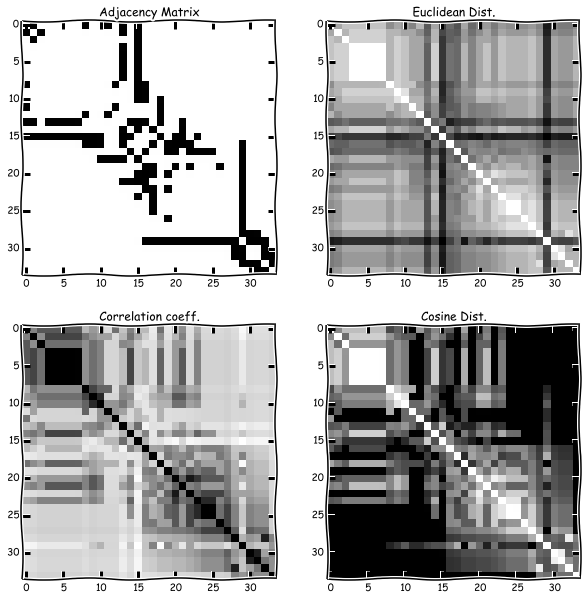

In [19]:
# Put your code here
#
#
G = nx.karate_club_graph()

# run procedure
cm = nx.utils.reverse_cuthill_mckee_ordering(G)
# get permutation
l = [n for n in cm]
l

A = nx.to_numpy_matrix(G)
A = np.asarray(A)
# apply reordering
A = A[np.ix_(l,l)]

plotDist(A)



###  Task 3 - Assortative Mixing

For this task you should download some data, convert it to network and calculate assortative mixing coefficient. Particularly, download [*GOT data*](https://github.com/FutureUnleashed/OSS/tree/master/Neo4j/GOT_Tree): [*characters*](https://www.hse.ru/data/2016/03/15/1127718485/characters.csv) and [*events*](https://www.hse.ru/data/2016/03/15/1127718470/events.csv) datasets.

The first dataset provides information on characters of the Game Of Thrones universe. The second one -- describes some events that have occured with them during the story. We are interested in **killing** events since they can be considered as binary relations and consequently -- graphs. 
The attribute wrt which we are going to compute assortative mixing is called "Team".

We will explore datasets with *pandas* module. The list of usefull functions:
* read_csv()
* characters.head()
* dropna
* set_index('characterID')['Team'].to_dict()
* events[events['event'] == 'killed']

In [20]:
# Put your code here
#
#
events = pd.read_csv('events.csv')
characters = pd.read_csv('characters.csv')


In [36]:
characters.head()

,characterID,Name,Team,isDead,isCaptured,isHurt,title,prefix
0,2,Addam Marbrand,Lannister,0,0,0,knight,Ser
1,1894,Adrack Humble,Greyjoy,0,0,0,NaN,NaN
2,7,Aegon Frey (Jinglebell),Frey (North),0,0,0,NaN,NaN
3,8,Aegon I Targaryen,Targaryen,1,0,0,King of the Seven Kingdoms,King
4,12,Aegon Targaryen,Targaryen,1,0,0,prince,Prince


In [29]:
kill_events = events[events['event'] == 'killed']
kill_events = pd.DataFrame(kill_events, index = None, columns=['characterID', 'event', 'withID'])
kill_events = kill_events.dropna()

In [31]:
kill_events.head()

,characterID,event,withID
7,1808,killed,2068
9,1825,killed,1808
25,557,killed,456
289,1186,killed,1528
518,755,killed,629


In [55]:
G = nx.DiGraph()

for row, data in kill_events.iterrows():
    killer = data[2]
    killed = data[0]
    G.add_edge(killer, killed)

In [56]:
ch_team = characters.set_index('characterID')['Team'].to_dict()
for k in ch_team.keys():
    if k not in G.nodes():
        del ch_team[k]

In [57]:
nx.set_node_attributes(G, 'Team', ch_team)

In [63]:
nx.assortativity.attribute_assortativity_coefficient(G, 'Team')
as_dict = nx.assortativity.attribute_mixing_dict(G, 'Team')
as_dict

{'Bolton (Lannister)': {},
 'Bolton (North)': {'Bolton (Lannister)': 1,
  'Greyjoy': 1,
  'Stark': 3,
  'none': 1},
 'Brave Companions': {'Lannister': 2, 'none': 1},
 'Citadel': {},
 'Drogo': {'Drogo': 1, 'Targaryen': 1},
 'Essos': {'Targaryen': 2},
 'Faceless Men': {'Citadel': 1, 'Lannister': 2},
 'Frey (Lannister)': {},
 'Frey (North)': {'Stark': 3},
 'Greyjoy': {'Greyjoy': 4,
  'Stark': 4,
  'Tyrell': 1,
  'Wildlings (north of wall)': 1},
 'Lannister': {'Frey (Lannister)': 2,
  'Lannister': 1,
  'Robert': 2,
  'Stark': 4,
  'none': 1},
 'Littlefinger': {'Littlefinger': 1, 'Robert': 1},
 'Martell': {'Robert': 1},
 'Night Watch': {'Night Watch': 4,
  'Tyrell': 1,
  'Wildlings (north of wall)': 5},
 'Red God': {'Renly': 2, 'Stannis': 4},
 'Renly': {'Brave Companions': 3, 'Stark': 1, 'none': 1},
 'Robert': {'Brave Companions': 2,
  'Essos': 1,
  'Martell': 1,
  'Robert': 5,
  'Second Sons': 1,
  'Stark': 4},
 'Second Sons': {},
 'Stannis': {},
 'Stark': {'Bolton (Lannister)': 1,
  'Brav

# Home Task for Testing Assortativity

1. Experiment with GoT data, use different similarity metrics. Explain the results. You may choose another dataset on any TV channel serialization.

2. Find the example of temporal network, that increases assortativity at early stages and became higly disassortative later.
Explain this process.

3. Take biological network. Let's prun the largest-degree nodes of a growing scale-free network has the effect of decreasing the degree correlation coefficient (assortativity) in a stable way, while keeping both the trait of a power-law degree distribution and the main properties of network's robustness. Explain the results. Propose a generative model for disassortative growing scale-free networks.
